## 6.1 Flavors of BERT

In [2]:
from transformers import pipeline

In [3]:
#pip install torch

In [4]:
nlp = pipeline("fill-mask", model='bert-base-cased')

print(type(nlp.model))

preds = nlp(f"If you don’t {nlp.tokenizer.mask_token} at the sign, you will get a ticket")

print('If you don’t *** at the sign, you will get a ticket')

for p in preds:
    print(f"Token:{p['token_str']}. Score: {100*p['score']:,.2f}%")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<class 'transformers.models.bert.modeling_bert.BertForMaskedLM'>
If you don’t *** at the sign, you will get a ticket
Token:look. Score: 51.35%
Token:stop. Score: 39.66%
Token:glance. Score: 1.02%
Token:wait. Score: 0.60%
Token:turn. Score: 0.57%


In [5]:
nlp = pipeline("fill-mask", model='roberta-base')

print(type(nlp.model))

preds = nlp(f"If you don’t {nlp.tokenizer.mask_token} at the sign, you will get a ticket")

print('If you don’t *** at the sign, you will get a ticket')

for p in preds:
    print(f"Token:{p['token_str']}. Score: {100*p['score']:,.2f}%")

<class 'transformers.models.roberta.modeling_roberta.RobertaForMaskedLM'>
If you don’t *** at the sign, you will get a ticket
Token: look. Score: 47.69%
Token: stop. Score: 36.82%
Token: stand. Score: 2.54%
Token: stay. Score: 2.52%
Token: wave. Score: 1.01%


In [6]:
nlp = pipeline("fill-mask", model='distilroberta-base')

print(type(nlp.model))

preds = nlp(f"If you don’t {nlp.tokenizer.mask_token} at the sign, you will get a ticket")

print('If you don’t *** at the sign, you will get a ticket')

for p in preds:
    print(f"Token:{p['token_str']}. Score: {100*p['score']:,.2f}%")

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<class 'transformers.models.roberta.modeling_roberta.RobertaForMaskedLM'>
If you don’t *** at the sign, you will get a ticket
Token: stop. Score: 42.11%
Token: look. Score: 7.53%
Token: park. Score: 4.92%
Token: arrive. Score: 4.65%
Token: sign. Score: 4.27%


In [7]:
nlp = pipeline("fill-mask", model='distilbert-base-cased')  # Using a flavor of BERT called DistilBERT

print(type(nlp.model))  

preds = nlp(f"If you don’t {nlp.tokenizer.mask_token} at the sign, you will get a ticket")

print('If you don’t *** at the sign, you will get a ticket')

for p in preds:
    print(f"Token:{p['token_str']}. Score: {100*p['score']:,.2f}%")

<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForMaskedLM'>
If you don’t *** at the sign, you will get a ticket
Token:look. Score: 57.46%
Token:stop. Score: 7.37%
Token:glance. Score: 3.74%
Token:arrive. Score: 2.16%
Token:appear. Score: 1.87%


## 6.2 BERT for sequence classification


In [8]:
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizerFast, \
     DataCollatorWithPadding, pipeline
from datasets import load_metric, Dataset
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [9]:
snips_file = open('D:/Codes/Data/snips.train.txt', 'rb')

snips_rows = snips_file.readlines()

snips_rows[:20]

[b'listen O\r\n',
 b'to O\r\n',
 b'westbam B-artist\r\n',
 b'alumb O\r\n',
 b'allergic B-album\r\n',
 b'on O\r\n',
 b'google B-service\r\n',
 b'music I-service\r\n',
 b'PlayMusic\r\n',
 b'\r\n',
 b'add O\r\n',
 b'step B-entity_name\r\n',
 b'to I-entity_name\r\n',
 b'me I-entity_name\r\n',
 b'to O\r\n',
 b'the O\r\n',
 b'50 B-playlist\r\n',
 b'cl\xc3\xa1sicos I-playlist\r\n',
 b'playlist O\r\n',
 b'AddToPlaylist\r\n']

In [10]:
# This code segment parses the snips dataset into a more manageable format

utterances = []
tokenized_utterances = []
labels_for_tokens = []
sequence_labels = []

utterance, tokenized_utterance, label_for_utterances = '', [], []
for snip_row in snips_rows:
    if len(snip_row) == 2:  # skip over rows with no data
        continue
    if ' ' not in snip_row.decode():  # we've hit a sequence label
        sequence_labels.append(snip_row.decode().strip())
        utterances.append(utterance.strip())
        tokenized_utterances.append(tokenized_utterance)
        labels_for_tokens.append(label_for_utterances)
        utterance = ''
        tokenized_utterance = []
        label_for_utterances = []
        continue
    token, token_label = snip_row.decode().split(' ')
    token_label = token_label.strip()
    utterance += f'{token} '
    tokenized_utterance.append(token)
    label_for_utterances.append(token_label)
    

In [11]:
len(labels_for_tokens), len(tokenized_utterances), len(utterances), len(sequence_labels)

(13084, 13084, 13084, 13084)

In [12]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

In [13]:
unique_sequence_labels = list(set(sequence_labels))
unique_sequence_labels

['SearchCreativeWork',
 'BookRestaurant',
 'SearchScreeningEvent',
 'PlayMusic',
 'GetWeather',
 'AddToPlaylist',
 'RateBook']

In [14]:
sequence_labels = [unique_sequence_labels.index(l) for l in sequence_labels]

print(f'There are {len(unique_sequence_labels)} unique sequence labels')

There are 7 unique sequence labels


In [15]:
from functools import reduce

unique_token_labels = list(set(reduce(lambda x, y: x + y, labels_for_tokens)))
labels_for_tokens = [[unique_token_labels.index(_) for _ in l] for l in labels_for_tokens]

print(f'There are {len(unique_token_labels)} unique token labels')

There are 72 unique token labels


In [16]:
print(tokenized_utterances[0])
print(labels_for_tokens[0])
print([unique_token_labels[l] for l in labels_for_tokens[0]])
print(utterances[0])
print(sequence_labels[0])
print(unique_sequence_labels[sequence_labels[0]])

['listen', 'to', 'westbam', 'alumb', 'allergic', 'on', 'google', 'music']
[51, 51, 9, 51, 16, 51, 24, 43]
['O', 'O', 'B-artist', 'O', 'B-album', 'O', 'B-service', 'I-service']
listen to westbam alumb allergic on google music
3
PlayMusic


In [17]:
snips_dataset = Dataset.from_dict(
    dict(
        utterance=utterances, 
        label=sequence_labels,
        tokens=tokenized_utterances,
        token_labels=labels_for_tokens
    )
)
snips_dataset = snips_dataset.train_test_split(test_size=0.2)

In [18]:
snips_dataset['train'][0]

{'utterance': 'can you pull up a track on zvooq by graham mcpherson',
 'label': 3,
 'tokens': ['can',
  'you',
  'pull',
  'up',
  'a',
  'track',
  'on',
  'zvooq',
  'by',
  'graham',
  'mcpherson'],
 'token_labels': [51, 51, 51, 51, 51, 37, 51, 24, 51, 9, 61]}

In [19]:
# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):
    return tokenizer(examples["utterance"], truncation=True)

In [20]:
seq_clf_tokenized_snips = snips_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/10467 [00:00<?, ? examples/s]

Map:   0%|          | 0/2617 [00:00<?, ? examples/s]

In [21]:
seq_clf_tokenized_snips['train'][0]

{'utterance': 'can you pull up a track on zvooq by graham mcpherson',
 'label': 3,
 'tokens': ['can',
  'you',
  'pull',
  'up',
  'a',
  'track',
  'on',
  'zvooq',
  'by',
  'graham',
  'mcpherson'],
 'token_labels': [51, 51, 51, 51, 51, 37, 51, 24, 51, 9, 61],
 'input_ids': [101,
  1169,
  1128,
  3373,
  1146,
  170,
  1854,
  1113,
  195,
  6005,
  1186,
  4426,
  1118,
  176,
  10659,
  2312,
  182,
  1665,
  15940,
  2142,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [22]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the 
#  length of the longest element in the batch, making them all the same length. 
#  It's possible to pad your text in the tokenizer function with padding=True, dynamic padding is more efficient.

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [23]:
# Data Collator will pad data so that all examples are the same input length.
#  Attention mask is how we ignore attention scores for padding tokens

In [24]:
sequence_clf_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased', 
    num_labels=len(unique_sequence_labels),
)

# set an index -> label dictionary
sequence_clf_model.config.id2label = {i: l for i, l in enumerate(unique_sequence_labels)}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
sequence_clf_model.config.id2label[0]

'SearchCreativeWork'

In [26]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):  # custom method to take in logits and calculate accuracy of the eval set
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


C:\Users\Mural\AppData\Local\Temp\ipykernel_11160\2176569874.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [27]:
#conda install -c huggingface transformers


In [28]:
epochs = 2

training_args = TrainingArguments(
    output_dir="./snips_clf/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
    
    # some deep learning parameters that the Trainer is able to take in
    warmup_steps=len(seq_clf_tokenized_snips['train']) // 5,  # number of warmup steps for learning rate scheduler,
    weight_decay = 0.05,
    
    logging_steps=1,
    log_level='info',
    evaluation_strategy='epoch',
    eval_steps=50,
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=sequence_clf_model,
    args=training_args,
    train_dataset=seq_clf_tokenized_snips['train'],
    eval_dataset=seq_clf_tokenized_snips['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [29]:
# Get initial metrics
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tokens, token_labels, utterance. If tokens, token_labels, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 1.9508953094482422,
 'eval_accuracy': 0.13679786014520443,
 'eval_runtime': 36.584,
 'eval_samples_per_second': 71.534,
 'eval_steps_per_second': 2.241}

In [30]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tokens, token_labels, utterance. If tokens, token_labels, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 10,467
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 656
  Number of trainable parameters = 65,786,887


Epoch,Training Loss,Validation Loss,Accuracy
1,0.079100,0.146557,0.976309
2,0.010700,0.066115,0.984715


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tokens, token_labels, utterance. If tokens, token_labels, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Saving model checkpoint to ./snips_clf/results\checkpoint-328
Configuration saved in ./snips_clf/results\checkpoint-328\config.json
Model weights saved in ./snips_clf/results\checkpoint-328\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tokens, token_labels, utterance. If tokens, token_labels, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Sa

TrainOutput(global_step=656, training_loss=0.6657797826110476, metrics={'train_runtime': 1412.1822, 'train_samples_per_second': 14.824, 'train_steps_per_second': 0.465, 'total_flos': 131290002583032.0, 'train_loss': 0.6657797826110476, 'epoch': 2.0})

In [31]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tokens, token_labels, utterance. If tokens, token_labels, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


{'eval_loss': 0.06611526012420654,
 'eval_accuracy': 0.9847153228888039,
 'eval_runtime': 47.489,
 'eval_samples_per_second': 55.107,
 'eval_steps_per_second': 1.727,
 'epoch': 2.0}

In [32]:
pipe = pipeline("text-classification", sequence_clf_model, tokenizer=tokenizer)
pipe('Please add Here We Go by Dispatch to my road trip playlist')

[{'label': 'AddToPlaylist', 'score': 0.9945259094238281}]

In [33]:
trainer.save_model()

Saving model checkpoint to ./snips_clf/results
Configuration saved in ./snips_clf/results\config.json
Model weights saved in ./snips_clf/results\pytorch_model.bin


In [34]:
pipe = pipeline("text-classification", "./snips_clf/results", tokenizer=tokenizer)
pipe('Please add Here We Go by Dispatch to my road trip playlist')

loading configuration file ./snips_clf/results\config.json
Model config DistilBertConfig {
  "_name_or_path": "./snips_clf/results",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "SearchCreativeWork",
    "1": "BookRestaurant",
    "2": "SearchScreeningEvent",
    "3": "PlayMusic",
    "4": "GetWeather",
    "5": "AddToPlaylist",
    "6": "RateBook"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype":

[{'label': 'AddToPlaylist', 'score': 0.9945259094238281}]

In [35]:
frozen_sequence_clf_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased', 
    num_labels=len(unique_sequence_labels),
)

loading configuration file config.json from cache at C:\Users\Mural/.cache\huggingface\hub\models--distilbert-base-cased\snapshots\0dacbb01d604f8adeeb5b87c9339e485ac40d5c0\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.32.1",
  "

In [36]:
for param in frozen_sequence_clf_model.distilbert.parameters():
    param.requires_grad = False

In [37]:
epochs = 2

training_args = TrainingArguments(
    output_dir="./snips_clf/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
    
    # some deep learning parameters that the Trainer is able to take in
    warmup_steps=len(seq_clf_tokenized_snips['train']) // 5,  # number of warmup steps for learning rate scheduler,
    weight_decay = 0.05,
    
    logging_steps=1,
    log_level='info',
    evaluation_strategy='epoch',
    eval_steps=50,
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=frozen_sequence_clf_model,
    args=training_args,
    train_dataset=seq_clf_tokenized_snips['train'],
    eval_dataset=seq_clf_tokenized_snips['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [38]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tokens, token_labels, utterance. If tokens, token_labels, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


{'eval_loss': 1.9633152484893799,
 'eval_accuracy': 0.13450515857852502,
 'eval_runtime': 48.4664,
 'eval_samples_per_second': 53.996,
 'eval_steps_per_second': 1.692}

In [39]:
trainer.train()  # ~23min -> ~6min on my laptop with all of distilbert frozen with a worse loss/accuracy

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tokens, token_labels, utterance. If tokens, token_labels, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 10,467
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 656
  Number of trainable parameters = 595,975


Epoch,Training Loss,Validation Loss,Accuracy
1,1.861600,1.893404,0.404280
2,1.792800,1.686055,0.846389


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tokens, token_labels, utterance. If tokens, token_labels, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Saving model checkpoint to ./snips_clf/results\checkpoint-328
Configuration saved in ./snips_clf/results\checkpoint-328\config.json
Model weights saved in ./snips_clf/results\checkpoint-328\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tokens, token_labels, utterance. If tokens, token_labels, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Sa

TrainOutput(global_step=656, training_loss=1.8787123697196566, metrics={'train_runtime': 484.8646, 'train_samples_per_second': 43.175, 'train_steps_per_second': 1.353, 'total_flos': 131290002583032.0, 'train_loss': 1.8787123697196566, 'epoch': 2.0})

In [40]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tokens, token_labels, utterance. If tokens, token_labels, utterance are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


{'eval_loss': 1.6860547065734863,
 'eval_accuracy': 0.8463889950324799,
 'eval_runtime': 48.224,
 'eval_samples_per_second': 54.268,
 'eval_steps_per_second': 1.7,
 'epoch': 2.0}

## 6.3 BERT for token classification

In [41]:
from transformers import DataCollatorForTokenClassification, DistilBertForTokenClassification, \
                         DistilBertTokenizerFast, pipeline

In [42]:
# using a cased tokenizer because I think case will matter
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

loading file vocab.txt from cache at C:\Users\Mural/.cache\huggingface\hub\models--distilbert-base-cased\snapshots\0dacbb01d604f8adeeb5b87c9339e485ac40d5c0\vocab.txt
loading file tokenizer.json from cache at C:\Users\Mural/.cache\huggingface\hub\models--distilbert-base-cased\snapshots\0dacbb01d604f8adeeb5b87c9339e485ac40d5c0\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\Mural/.cache\huggingface\hub\models--distilbert-base-cased\snapshots\0dacbb01d604f8adeeb5b87c9339e485ac40d5c0\tokenizer_config.json
loading configuration file config.json from cache at C:\Users\Mural/.cache\huggingface\hub\models--distilbert-base-cased\snapshots\0dacbb01d604f8adeeb5b87c9339e485ac40d5c0\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0

In [43]:
snips_dataset['train'][0]

{'utterance': 'can you pull up a track on zvooq by graham mcpherson',
 'label': 3,
 'tokens': ['can',
  'you',
  'pull',
  'up',
  'a',
  'track',
  'on',
  'zvooq',
  'by',
  'graham',
  'mcpherson'],
 'token_labels': [51, 51, 51, 51, 51, 37, 51, 24, 51, 9, 61]}

In [44]:
# The given "token_labels" may not match up with the BERT wordpiece tokenization so
#  this function will map them to the tokenization that BERT uses
#  -100 is a reserved for labels where we do not want to calculate losses so BERT doesn't waste time
#  trying to predict tokens like CLS or SEP

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"token_labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:  # Set the special tokens to -100.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)  # CLS and SEP are labeled as -100
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [45]:
snips_dataset['train'][0]

{'utterance': 'can you pull up a track on zvooq by graham mcpherson',
 'label': 3,
 'tokens': ['can',
  'you',
  'pull',
  'up',
  'a',
  'track',
  'on',
  'zvooq',
  'by',
  'graham',
  'mcpherson'],
 'token_labels': [51, 51, 51, 51, 51, 37, 51, 24, 51, 9, 61]}

In [46]:
# map our dataset from sequence classification to be for token classification
tok_clf_tokenized_snips = snips_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/10467 [00:00<?, ? examples/s]

Map:   0%|          | 0/2617 [00:00<?, ? examples/s]

In [47]:
tok_clf_tokenized_snips['train'][0]

{'utterance': 'can you pull up a track on zvooq by graham mcpherson',
 'label': 3,
 'tokens': ['can',
  'you',
  'pull',
  'up',
  'a',
  'track',
  'on',
  'zvooq',
  'by',
  'graham',
  'mcpherson'],
 'token_labels': [51, 51, 51, 51, 51, 37, 51, 24, 51, 9, 61],
 'input_ids': [101,
  1169,
  1128,
  3373,
  1146,
  170,
  1854,
  1113,
  195,
  6005,
  1186,
  4426,
  1118,
  176,
  10659,
  2312,
  182,
  1665,
  15940,
  2142,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [-100,
  51,
  51,
  51,
  51,
  51,
  37,
  51,
  24,
  -100,
  -100,
  -100,
  51,
  9,
  -100,
  -100,
  61,
  -100,
  -100,
  -100,
  -100]}

In [48]:
tok_clf_tokenized_snips['train'] = tok_clf_tokenized_snips['train'].remove_columns(
    ['utterance', 'label', 'tokens', 'token_labels']
)

tok_clf_tokenized_snips['test'] = tok_clf_tokenized_snips['test'].remove_columns(
    ['utterance', 'label', 'tokens', 'token_labels']
)

tok_clf_tokenized_snips

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10467
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2617
    })
})

In [49]:
tok_data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [50]:
tok_clf_model = DistilBertForTokenClassification.from_pretrained(
    'distilbert-base-cased', num_labels=len(unique_token_labels)
)

# Set our label dictionary
tok_clf_model.config.id2label = {i: l for i, l in enumerate(unique_token_labels)}

loading configuration file config.json from cache at C:\Users\Mural/.cache\huggingface\hub\models--distilbert-base-cased\snapshots\0dacbb01d604f8adeeb5b87c9339e485ac40d5c0\config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "L

In [51]:
tok_clf_model.config.id2label[0], tok_clf_model.config.id2label[1]

('I-restaurant_name', 'B-object_select')

In [52]:
epochs = 2

training_args = TrainingArguments(
    output_dir="./snips_tok_clf/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
        
    logging_steps=10,
    log_level='info',
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=tok_clf_model,
    args=training_args,
    train_dataset=tok_clf_tokenized_snips['train'],
    eval_dataset=tok_clf_tokenized_snips['test'],
    data_collator=tok_data_collator
)

Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [53]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 4.265631675720215,
 'eval_runtime': 47.5168,
 'eval_samples_per_second': 55.075,
 'eval_steps_per_second': 1.726}

In [54]:
trainer.train()

***** Running training *****
  Num examples = 10,467
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 656
  Number of trainable parameters = 65,246,280


Epoch,Training Loss,Validation Loss
1,0.222200,0.161771
2,0.109900,0.118528


***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Saving model checkpoint to ./snips_tok_clf/results\checkpoint-328
Configuration saved in ./snips_tok_clf/results\checkpoint-328\config.json
Model weights saved in ./snips_tok_clf/results\checkpoint-328\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
Saving model checkpoint to ./snips_tok_clf/results\checkpoint-656
Configuration saved in ./snips_tok_clf/results\checkpoint-656\config.json
Model weights saved in ./snips_tok_clf/results\checkpoint-656\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./snips_tok_clf/results\checkpoint-656 (score: 0.11852755397558212).


TrainOutput(global_step=656, training_loss=0.38637346047453763, metrics={'train_runtime': 1982.5731, 'train_samples_per_second': 10.559, 'train_steps_per_second': 0.331, 'total_flos': 129644165657664.0, 'train_loss': 0.38637346047453763, 'epoch': 2.0})

In [55]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


{'eval_loss': 0.11852755397558212,
 'eval_runtime': 50.2248,
 'eval_samples_per_second': 52.106,
 'eval_steps_per_second': 1.633,
 'epoch': 2.0}

In [56]:
pipe = pipeline("token-classification", tok_clf_model, tokenizer=tokenizer)
pipe('Please add Here We Go by Dispatch to my road trip playlist')

Disabling tokenizer parallelism, we're using DataLoader multithreading already


[{'entity': 'B-entity_name',
  'score': 0.9442455,
  'index': 3,
  'word': 'Here',
  'start': 11,
  'end': 15},
 {'entity': 'I-entity_name',
  'score': 0.9581642,
  'index': 4,
  'word': 'We',
  'start': 16,
  'end': 18},
 {'entity': 'I-entity_name',
  'score': 0.96075714,
  'index': 5,
  'word': 'Go',
  'start': 19,
  'end': 21},
 {'entity': 'B-artist',
  'score': 0.9584691,
  'index': 7,
  'word': 'Di',
  'start': 25,
  'end': 27},
 {'entity': 'I-artist',
  'score': 0.9229686,
  'index': 8,
  'word': '##sp',
  'start': 27,
  'end': 29},
 {'entity': 'I-artist',
  'score': 0.80200887,
  'index': 9,
  'word': '##atch',
  'start': 29,
  'end': 33},
 {'entity': 'B-playlist_owner',
  'score': 0.9954868,
  'index': 11,
  'word': 'my',
  'start': 37,
  'end': 39},
 {'entity': 'B-playlist',
  'score': 0.99491453,
  'index': 12,
  'word': 'road',
  'start': 40,
  'end': 44},
 {'entity': 'I-playlist',
  'score': 0.99570906,
  'index': 13,
  'word': 'trip',
  'start': 45,
  'end': 49}]

In [57]:
pipe = pipeline("token-classification", tok_clf_model, tokenizer=tokenizer)
pipe('Rate the doog food 5 out of 5')

[{'entity': 'B-object_name',
  'score': 0.9280334,
  'index': 2,
  'word': 'the',
  'start': 5,
  'end': 8},
 {'entity': 'I-object_name',
  'score': 0.93365926,
  'index': 3,
  'word': 'do',
  'start': 9,
  'end': 11},
 {'entity': 'I-object_name',
  'score': 0.9880337,
  'index': 4,
  'word': '##og',
  'start': 11,
  'end': 13},
 {'entity': 'I-object_name',
  'score': 0.98911613,
  'index': 5,
  'word': 'food',
  'start': 14,
  'end': 18},
 {'entity': 'B-rating_value',
  'score': 0.996618,
  'index': 6,
  'word': '5',
  'start': 19,
  'end': 20},
 {'entity': 'B-best_rating',
  'score': 0.8065398,
  'index': 9,
  'word': '5',
  'start': 28,
  'end': 29}]

## 6.4 BERT for question/answering

In [58]:
from transformers import BertTokenizerFast, BertForQuestionAnswering, pipeline, \
                         DataCollatorWithPadding, TrainingArguments, Trainer, \
                         AutoModelForQuestionAnswering, AutoTokenizer
from datasets import Dataset
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests

In [59]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased', return_token_type_ids=True)

qa_bert = BertForQuestionAnswering.from_pretrained('bert-large-uncased')

loading file vocab.txt from cache at C:\Users\Mural/.cache\huggingface\hub\models--bert-large-uncased\snapshots\80792f8e8216b29f3c846b653a0ff0a37c210431\vocab.txt
loading file tokenizer.json from cache at C:\Users\Mural/.cache\huggingface\hub\models--bert-large-uncased\snapshots\80792f8e8216b29f3c846b653a0ff0a37c210431\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\Mural/.cache\huggingface\hub\models--bert-large-uncased\snapshots\80792f8e8216b29f3c846b653a0ff0a37c210431\tokenizer_config.json
loading configuration file config.json from cache at C:\Users\Mural/.cache\huggingface\hub\models--bert-large-uncased\snapshots\80792f8e8216b29f3c846b653a0ff0a37c210431\config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gra

In [60]:
qa_df = pd.read_csv('D:/Codes/Data/qa.csv')

qa_df.shape

(29989, 5)

In [61]:
qa_df.head()

,question,context,start_positions,end_positions,answer
0,What sare the benifts of the blood brain barrir?,Another approach to brain function is to exami...,56,60,isolated from the bloodstream
1,What is surrounded by cerebrospinal fluid?,Another approach to brain function is to exami...,16,16,brain
2,What does the skull protect?,Another approach to brain function is to exami...,11,11,brain
3,What has been injected into rats to produce pr...,Another approach to brain function is to exami...,153,153,chemicals
4,What can cause issues with how the brain works?,Another approach to brain function is to exami...,93,94,brain damage


In [62]:
qa_df.iloc[0]

question            What sare the benifts of the blood brain barrir?
context            Another approach to brain function is to exami...
start_positions                                                   56
end_positions                                                     60
answer                                 isolated from the bloodstream
Name: 0, dtype: object

In [63]:
# index 56, 57, 58, 59, and 60 including question while encoding
bert_tokenizer.decode(bert_tokenizer.encode(qa_df.iloc[0].question, qa_df.iloc[0].context)[56:61])

'isolated from the bloodstream'

In [64]:
# only grab 4,000 examples
qa_dataset = Dataset.from_pandas(qa_df.sample(4000, random_state=42))

# Dataset has a built in train test split method
qa_dataset = qa_dataset.train_test_split(test_size=0.2)

In [65]:
# standard preprocessing here with truncation on to truncate longer text
def preprocess(data):
    return bert_tokenizer(data['question'], data['context'], truncation=True)

qa_dataset = qa_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [66]:
# freeze all but the last 2 encoder layers in BERT to speed up training
for name, param in qa_bert.bert.named_parameters():
    if 'encoder.layer.22' in name:
        break
    param.requires_grad = False  # disable training in BERT

In [67]:
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [68]:
batch_size = 32
epochs = 2

training_args = TrainingArguments(
    output_dir='./qa/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./qa/logs',
    save_strategy='epoch',
    logging_steps=10,
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)

trainer = Trainer(
    model=qa_bert,
    args=training_args,
    train_dataset=qa_dataset['train'],
    eval_dataset=qa_dataset['test'],
    data_collator=data_collator
)

# Get initial metrics
trainer.evaluate()

Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: __index_level_0__, context, answer, question. If __index_level_0__, context, answer, question are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 32
You're using a BertTo

{'eval_loss': 6.019111156463623,
 'eval_runtime': 2458.7993,
 'eval_samples_per_second': 0.325,
 'eval_steps_per_second': 0.01}

In [69]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: __index_level_0__, context, answer, question. If __index_level_0__, context, answer, question are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 3,200
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 200
  Number of trainable parameters = 25,194,498


Epoch,Training Loss,Validation Loss
1,4.467600,4.354722
2,4.326200,4.244605


The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: __index_level_0__, context, answer, question. If __index_level_0__, context, answer, question are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 32
Saving model checkpoint to ./qa/results\checkpoint-100
Configuration saved in ./qa/results\checkpoint-100\config.json
Model weights saved in ./qa/results\checkpoint-100\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: __index_level_0__, context, answer, question. If __index_level_0__, context, answer, question are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 32
Saving model chec

TrainOutput(global_step=200, training_loss=4.490904273986817, metrics={'train_runtime': 28993.3677, 'train_samples_per_second': 0.221, 'train_steps_per_second': 0.007, 'total_flos': 4233104514306432.0, 'train_loss': 4.490904273986817, 'epoch': 2.0})

In [70]:
# Q/A models are very large and take a long time to fine-tune

In [71]:
trainer.save_model()

Saving model checkpoint to ./qa/results
Configuration saved in ./qa/results\config.json
Model weights saved in ./qa/results\pytorch_model.bin


In [72]:
pipe = pipeline("question-answering", './qa/results', tokenizer=bert_tokenizer)

loading configuration file ./qa/results\config.json
Model config BertConfig {
  "_name_or_path": "./qa/results",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.32.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file ./qa/results\config.json
Model config BertConfig {
  "_name_or_path": "./qa/results",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_che

In [73]:
pipe("Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.")

{'score': 0.11053000390529633,
 'start': 0,
 'end': 25,
 'answer': 'Sinan lives in California'}

In [74]:
princeton = """In 1675, a Quaker missionary from England, encouraged by New Jersey proprietors John Lord 
              "Berkeley and Sir George Carteret, arrived to establish a settlement in this area near the 
              "Delaware River, which was inhabited by the Lenni-Lenape Indians. The Keith survey of 1685 
              "established the western boundary of Middlesex and Somerset Counties and later, the Township 
              "of Princeton. Today Keith's Line is recognized as Province Line Road. With the laying of the 
              "cornerstone for Nassau Hall in 1754, Princeton began its development as a location for 
              "quality education. Nassau Hall was named for William III, Prince of Orange-Nassau. This simple stone 
              "edifice was one of the largest public buildings in the colonies and became a model for many other 
              "structures in New Jersey and Pennsylvania."""

pipe("What survey led to the founding of Princeton?", princeton)

{'score': 0.002236125757917762,
 'start': 281,
 'end': 385,
 'answer': 'Keith survey of 1685 \n              "established the western boundary of Middlesex and Somerset Counties'}

In [75]:
PERSON = 'Sinan Ozdemir'

# Note this is NOT an efficient way to search on google. This is done simply for education purposes
google_html = BeautifulSoup(requests.get(f'https://www.google.com/search?q={PERSON}').text).get_text()[:512]

pipe(f'Who is {PERSON}?', google_html)

{'score': 0.001428805524483323,
 'start': 0,
 'end': 13,
 'answer': 'Sinan Ozdemir'}

In [76]:
# From Huggingface: https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad

squad_pipe = pipeline("question-answering", "bert-large-uncased-whole-word-masking-finetuned-squad")

loading configuration file config.json from cache at C:\Users\Mural/.cache\huggingface\hub\models--bert-large-uncased-whole-word-masking-finetuned-squad\snapshots\cca7eb4efca266eff710a8c7154ecbc382b78e77\config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.32.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file config.json from cache at C:\Users\Mural/.cache\huggingface\hub\models--bert-large-un

In [77]:
squad_pipe("Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.")

{'score': 0.9924461245536804, 'start': 15, 'end': 25, 'answer': 'California'}

In [78]:
squad_pipe("What survey led to the founding of Princeton?", princeton)

{'score': 0.3114531338214874,
 'start': 277,
 'end': 293,
 'answer': 'The Keith survey'}

In [79]:
# visualize logits
large_tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

qa_input = large_tokenizer(  # tokenize our example
    "What survey led to the founding of Princeton?", princeton,
    return_tensors='pt'
)

loading configuration file config.json from cache at C:\Users\Mural/.cache\huggingface\hub\models--bert-large-uncased-whole-word-masking-finetuned-squad\snapshots\cca7eb4efca266eff710a8c7154ecbc382b78e77\config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.32.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\Mural/.cache\huggingface\hub\models--bert-large-uncased-whole-word

In [80]:
large_qa_bert = AutoModelForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

output = large_qa_bert(**qa_input)  # pass the input through our QA model
output

loading configuration file config.json from cache at C:\Users\Mural/.cache\huggingface\hub\models--bert-large-uncased-whole-word-masking-finetuned-squad\snapshots\cca7eb4efca266eff710a8c7154ecbc382b78e77\config.json
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.32.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at C:\Users\Mural/.cache\huggingface\hub\models--bert-large-un

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-5.7519, -3.6147, -8.6238, -8.5794, -8.7563, -8.1872, -8.1031, -8.2268,
         -7.5512, -9.8327, -5.7519, -6.2746, -4.7468, -7.9981, -6.5231, -6.2942,
         -6.9675, -8.3130, -7.0369, -8.2833, -6.1628, -8.1123, -5.4992, -5.6526,
         -6.2635, -8.3655, -5.3692, -7.8447, -8.8567, -6.3198, -8.5963, -5.9721,
         -7.6135, -7.3562, -8.2679, -8.3762, -6.8817, -7.8090, -7.5480, -7.4207,
         -7.2773, -8.2750, -7.7373, -7.5004, -7.8319, -7.9563, -7.1041, -5.7036,
         -7.5340, -8.4661, -8.3033, -7.9716, -7.2749, -8.5451, -8.1295, -7.2359,
         -8.6795, -8.9292, -7.6118, -8.6576, -6.9020, -5.7518,  6.3959,  5.9311,
         -1.0083, -4.0455,  1.1958, -4.5241, -2.6724, -4.6225, -3.4796, -5.6253,
         -7.3676, -5.4171, -7.9947, -5.3715, -5.9689, -8.1691, -6.2237, -7.7371,
         -4.7933, -5.0089, -6.9667, -5.7007, -3.2038, -4.9603, -4.6802,  1.7422,
         -7.9737, -6.3608, -5.4654, -7.9430, -7.3093, -7

In [81]:
token_labels = large_tokenizer.convert_ids_to_tokens(qa_input['input_ids'].squeeze())

C:\Users\Mural\AppData\Local\Temp\ipykernel_11160\2438474572.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.start_logits.squeeze().tolist(), ci=None)


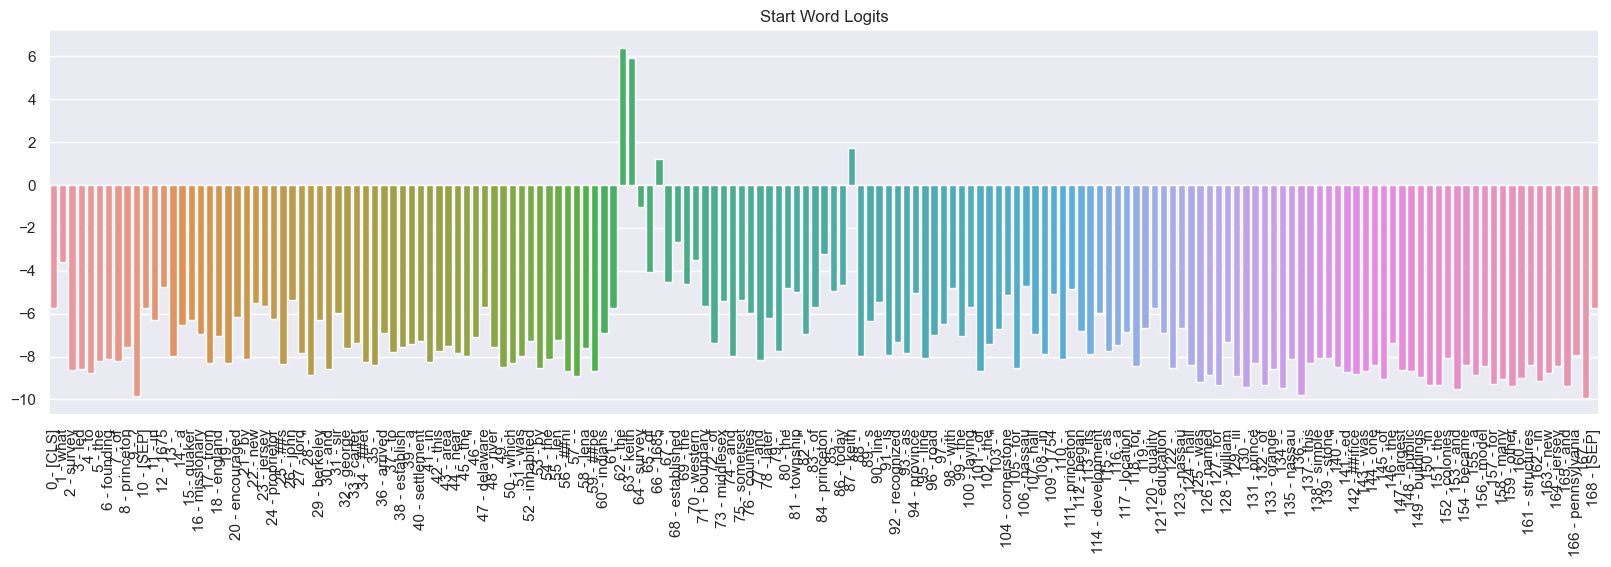

C:\Users\Mural\AppData\Local\Temp\ipykernel_11160\2438474572.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.end_logits.squeeze().tolist(), ci=None)


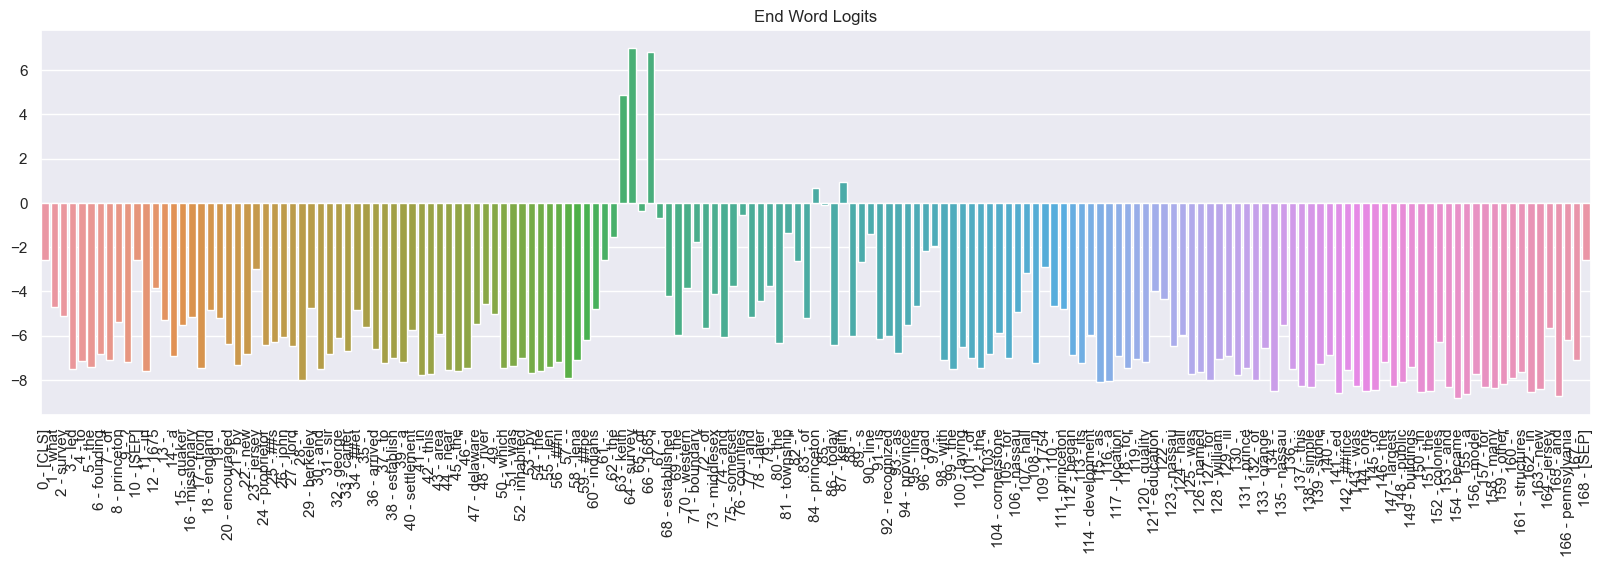

In [82]:
# Plot start and end logits for our fine-tuned model

sns.set(rc={"figure.figsize":(20, 5)}) 

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.start_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('Start Word Logits')

plt.show()

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.end_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('End Word Logits')

plt.show()